<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek37.do.txt  -->
<!-- dom:TITLE: Exercises week 37 -->

Simon Silverstein

# Exercises week 37
**Implementing gradient descent for Ridge and ordinary Least Squares Regression**

Date: **September 8-12, 2025**

## Learning goals

After having completed these exercises you will have:
1. Your own code for the implementation of the simplest gradient descent approach applied to ordinary least squares (OLS) and Ridge regression

2. Be able to compare the analytical expressions for OLS and Ridge regression with the gradient descent approach

3. Explore the role of the learning rate in the gradient descent approach and the hyperparameter $\lambda$ in Ridge regression

4. Scale the data properly

## Simple one-dimensional second-order polynomial

We start with a very simple function

$$
f(x)= 2-x+5x^2,
$$

defined for $x\in [-2,2]$. You can add noise if you wish. 

We are going to fit this function with a polynomial ansatz. The easiest thing is to set up a second-order polynomial and see if you can fit the above function.
Feel free to play around with higher-order polynomials.

In [30]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 600
})


## Exercise 1, scale your data

Before fitting a regression model, it is good practice to normalize or
standardize the features. This ensures all features are on a
comparable scale, which is especially important when using
regularization. Here we will perform standardization, scaling each
feature to have mean 0 and standard deviation 1.

### 1a)

Compute the mean and standard deviation of each column (feature) in your design/feature matrix $\boldsymbol{X}$.
Subtract the mean and divide by the standard deviation for each feature.

We will also center the target $\boldsymbol{y}$ to mean $0$. Centering $\boldsymbol{y}$
(and each feature) means the model does not require a separate intercept
term, the data is shifted such that the intercept is effectively 0
. (In practice, one could include an intercept in the model and not
penalize it, but here we simplify by centering.)
Choose $n=100$ data points and set up $\boldsymbol{x}, $\boldsymbol{y}$ and the design matrix $\boldsymbol{X}$.

In [31]:
x = np.linspace(-2, 2, 100)
noise = np.random.normal(0, 0.2, x.shape[0])

y = 2 - x + 5*x**2 + noise

In [32]:
# Taken from E3
def polynomial_features(x, p, intercept=False):
    lowest = 0 if intercept else 1
    orders = np.arange(lowest, p + 1)
    exp, base = np.meshgrid(orders, x)
    return base ** exp

In [33]:
X = polynomial_features(x, 2, intercept=False)

# Standardize features (zero mean, unit variance for each feature)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1  # safeguard to avoid division by zero for constant features
X_norm = (X - X_mean) / X_std

# Center the target to zero mean (optional, to simplify intercept handling)
y_mean = y.mean()
y_centered = y - y_mean

Fill in the necessary details. Do we need to center the $y$-values? 

After this preprocessing, each column of $\boldsymbol{X}_{\mathrm{norm}}$ has mean zero and standard deviation $1$
and $\boldsymbol{y}_{\mathrm{centered}}$ has mean 0. This makes the optimization landscape
nicer and ensures the regularization penalty $\lambda \sum_j
\theta_j^2$ in Ridge regression treats each coefficient fairly (since features are on the
same scale).

## Exercise 2, calculate the gradients

Find the gradients for OLS and Ridge regression using the mean-squared error as cost/loss function.

**Solution**
This is very similar to previous weeks. We'll start with the derivative for Ridge regression:

\begin{align*}
\nabla\boldsymbol{C}
    &= \frac{\partial}{\partial\boldsymbol{\theta}}\left(\frac{1}{n}
            (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta})^T(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta}) + \lambda\boldsymbol{\theta}^T\boldsymbol{\theta}
        \right) \\

&=    
    \left(- 2\frac{1}{n}(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{{\boldsymbol{\theta}}})^T\boldsymbol{X}
    + 2\lambda{\boldsymbol{\theta}}^T\right) \\

&= 2\left(\frac{1}{n}(\boldsymbol{X}\boldsymbol{{\boldsymbol{\theta}}} - \boldsymbol{y})^T\boldsymbol{X}
    + \lambda{\boldsymbol{\theta}}^T\right)\\

&= 2\left(\frac{1}{n}\boldsymbol{X}^T(\boldsymbol{X}\boldsymbol{{\boldsymbol{\theta}}} - \boldsymbol{y})
    + \lambda{\boldsymbol{\theta}}\right)\\

\end{align*}

From this, we can clearly see the OLS solution by setting $\lambda=0$.

$$
\nabla\boldsymbol{C}=\frac{2}{n}\boldsymbol{X}^T(\boldsymbol{X}\boldsymbol{{\boldsymbol{\theta}}} - \boldsymbol{y})
$$

In [34]:
def ols_grad(X, y, theta):
    return (2/y.shape[0]) * X.T@(X@theta - y)

def ridge_grad(X, y, theta, lam=0):
    return 2 * ((1/y.shape[0]) * X.T@(X@theta - y) + lam*theta)

## Exercise 3, using the analytical formulae for OLS and Ridge regression to find the optimal paramters $\boldsymbol{\theta}$

In [35]:
# Set regularization parameter, either a single value or a vector of values
# Note that lambda is a python keyword. The lambda keyword is used to create small, single-expression functions without a formal name. These are often called "anonymous functions" or "lambda functions."
lam = 1e-3


# Analytical form for OLS and Ridge solution: theta_Ridge = (X^T X + lambda * I)^{-1} X^T y and theta_OLS = (X^T X)^{-1} X^T y
I = np.eye(2)
theta_closed_formRidge = np.linalg.inv(X_norm.T @ X_norm + lam*np.identity(X.shape[1])) @ X_norm.T @ y_centered
theta_closed_formOLS = np.linalg.inv(X_norm.T@X_norm)@X_norm.T@y_centered

print("Closed-form Ridge coefficients:", theta_closed_formRidge)
print("Closed-form OLS coefficients:", theta_closed_formOLS)

Closed-form Ridge coefficients: [-1.17022173  6.07806556]
Closed-form OLS coefficients: [-1.17023343  6.07812634]


This computes the Ridge and OLS regression coefficients directly. The identity
matrix $I$ has the same size as $X^T X$. It adds $\lambda$ to the diagonal of $X^T X$ for Ridge regression. We
then invert this matrix and multiply by $X^T y$. The result
for $\boldsymbol{\theta}$  is a NumPy array of shape (n$\_$features,) containing the
fitted parameters $\boldsymbol{\theta}$.

### 3a)

Finalize, in the above code, the OLS and Ridge regression determination of the optimal parameters $\boldsymbol{\theta}$.

### 3b)

Explore the results as function of different values of the hyperparameter $\lambda$. See for example exercise 4 from week 36.

In [36]:
lams = np.logspace(-4,4, 100)

def ridge (X, y, lam): return np.linalg.inv(X.T @ X + lam*np.identity(X.shape[1])) @ X.T @ y

ridge_coef = np.array([ridge(X_norm, y_centered, l) for l in lams])

In [37]:
# let's also calculate MSE
def MSE(X, y, theta):
    return np.sum((X@theta - y)**2)/y.shape[0]

MSE_vec = np.vectorize(lambda t: MSE(X_norm, y_centered, t), signature='(2)->()')

mse = MSE_vec(ridge_coef)
mse_ols = MSE(X_norm, y_centered, theta_closed_formOLS)

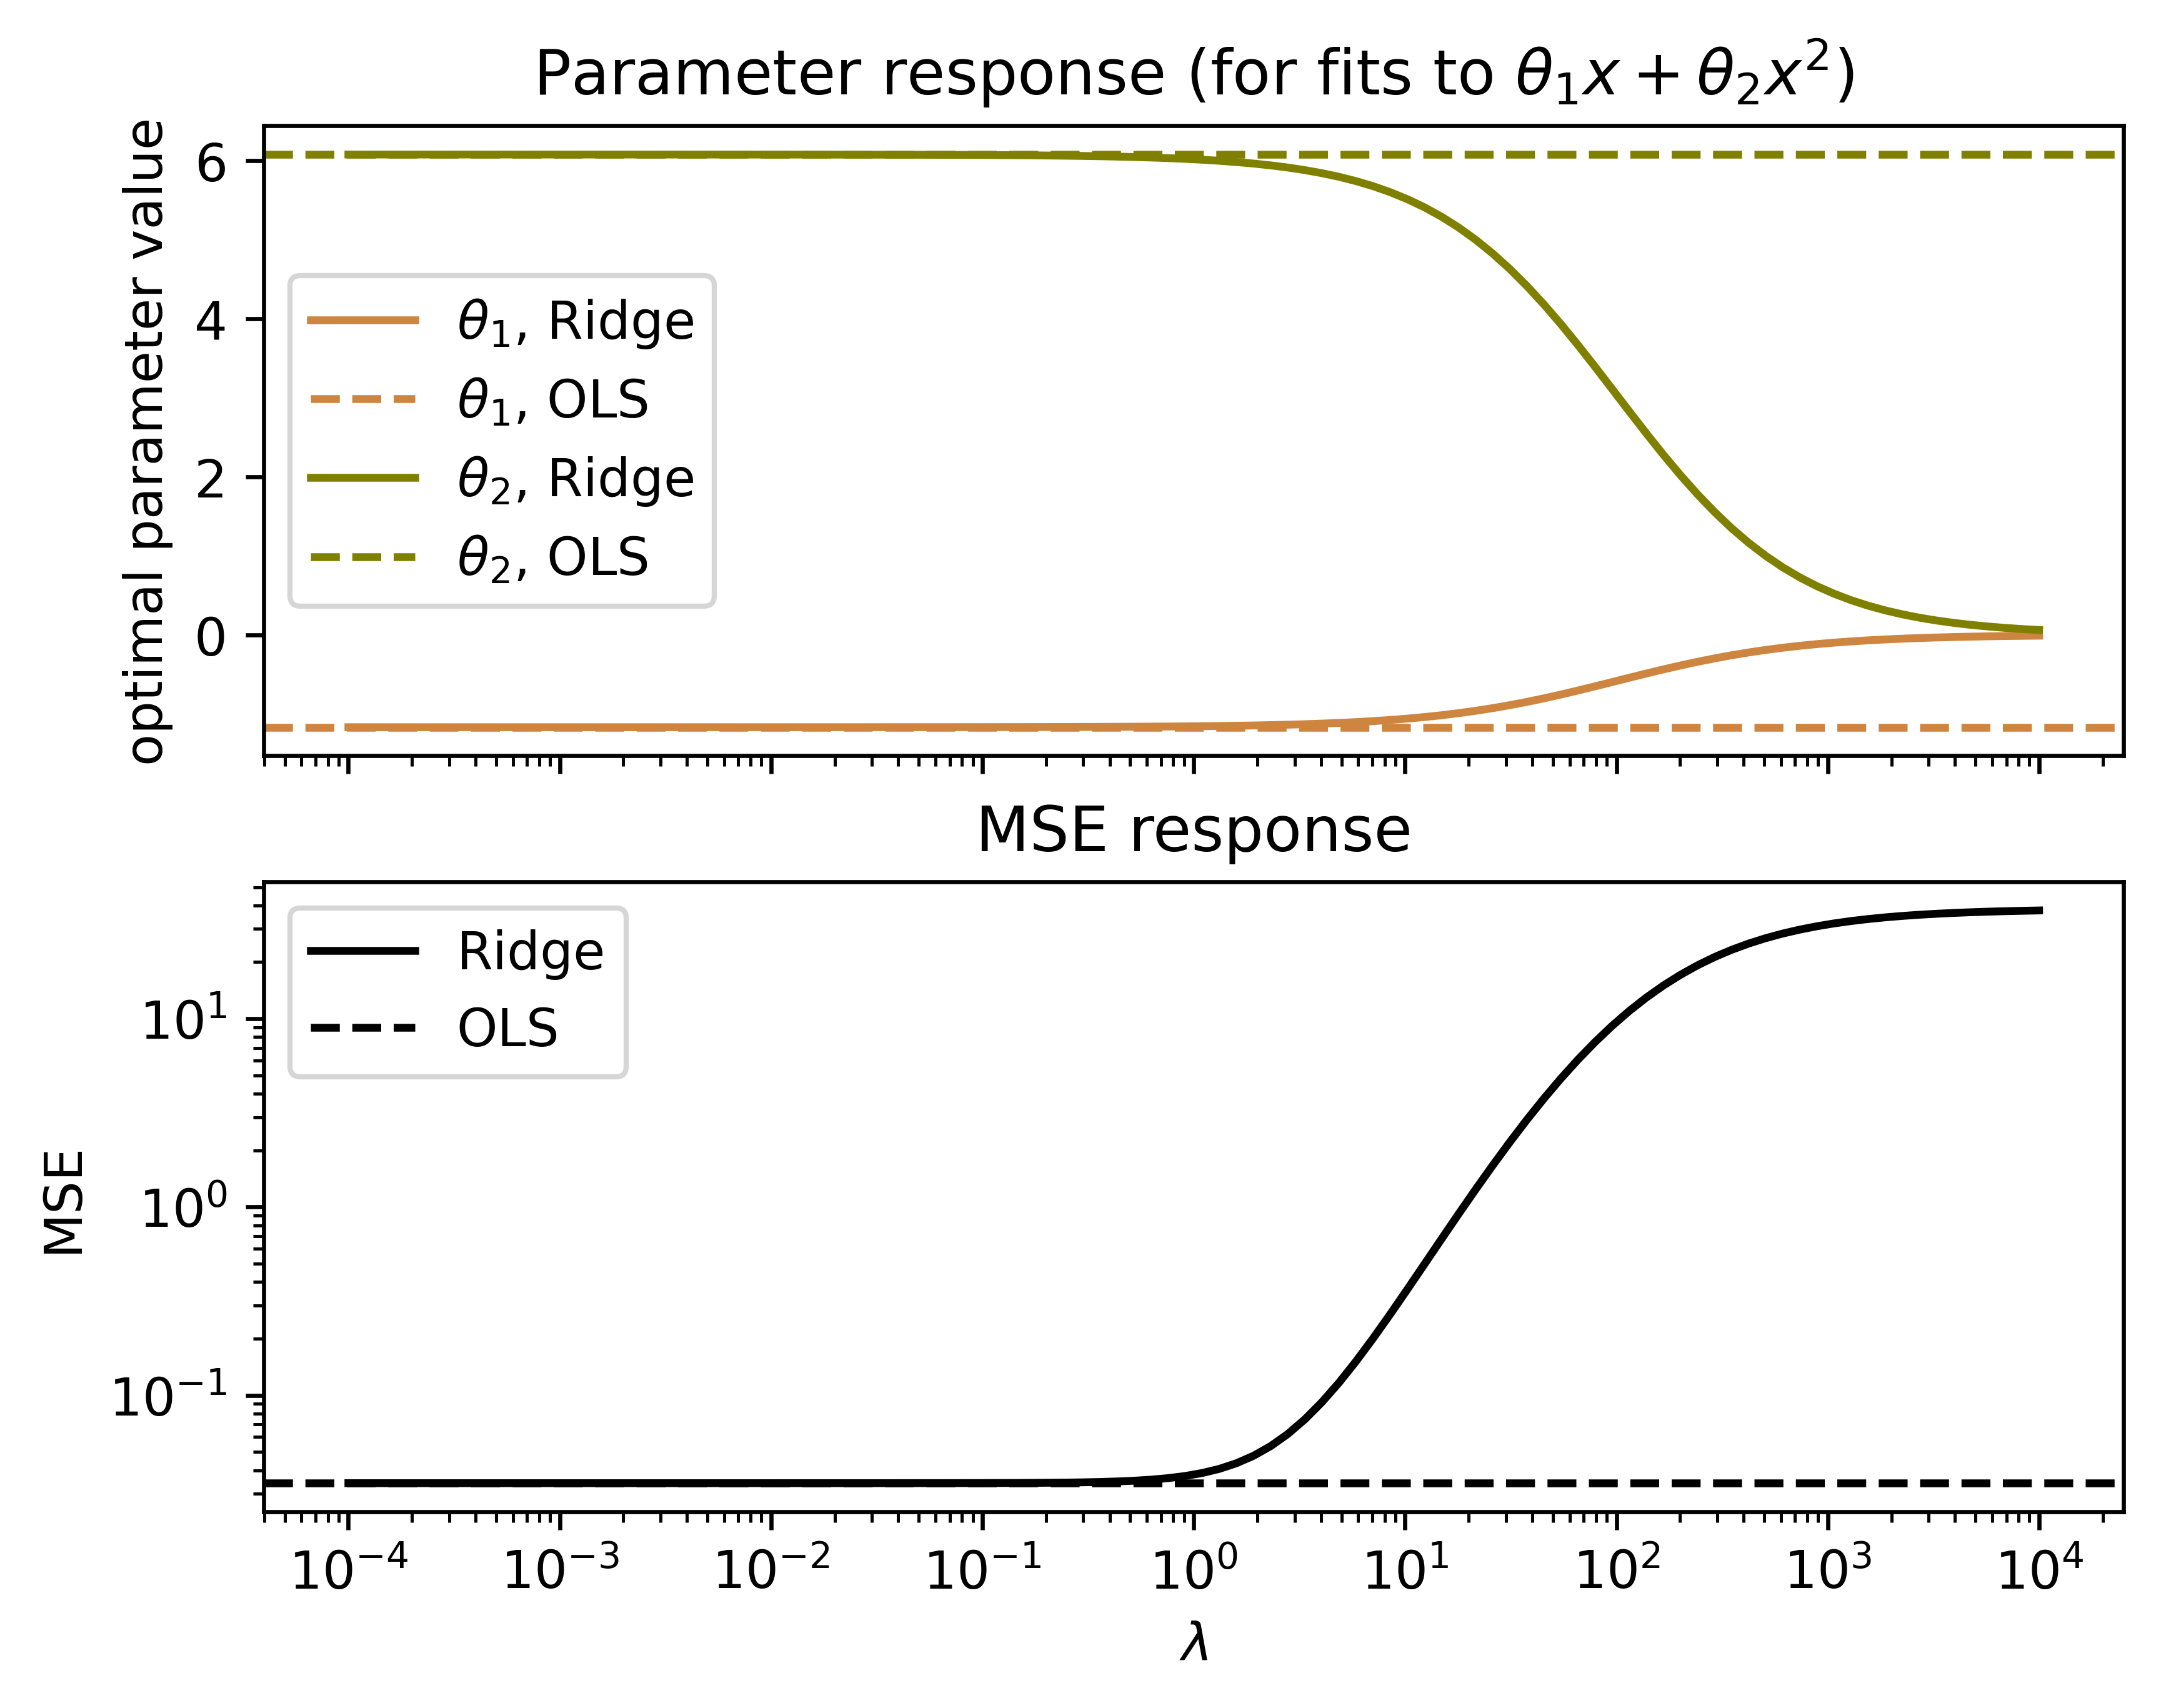

In [38]:
fig, axs = plt.subplots(2, sharex=True)

a1 = 'peru'
a2 = 'olive'

ax = axs[0]
ax.plot(lams, ridge_coef[:, 0], c=a1, label=r'$\theta_1$, Ridge')
ax.axhline(theta_closed_formOLS[0], ls='--', c=a1, label=r'$\theta_1$, OLS')

ax.plot(lams, ridge_coef[:, 1], c=a2, label=r'$\theta_2$, Ridge')
ax.axhline(theta_closed_formOLS[1], ls='--', c=a2, label=r'$\theta_2$, OLS')

ax.set_title(r'Parameter response (for fits to $\theta_1x + \theta_2x^2$)')
ax.set_ylabel('optimal parameter value')
ax.legend()


ax = axs[1]
c = 'k'
ax.plot(lams, mse, c=c, label='Ridge')
ax.axhline(mse_ols, c=c, ls='--', label='OLS')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('MSE')
ax.set_title(r'MSE response')
ax.legend()

## Exercise 4, Implementing the simplest form for gradient descent

Alternatively, we can fit the ridge regression model using gradient
descent. This is useful to visualize the iterative convergence and is
necessary if $n$ and $p$ are so large that the closed-form might be
too slow or memory-intensive. We derive the gradients from the cost
functions defined above. Use the gradients of the Ridge and OLS cost functions with respect to
the parameters  $\boldsymbol{\theta}$ and set up (using the template below) your own gradient descent code for OLS and Ridge regression.

Below is a template code for gradient descent implementation of ridge:

In [39]:
# Gradient descent parameters, learning rate eta first
eta = 0.1
# Then number of iterations
num_iters = 1000

# Initialize weights for gradient descent
theta = np.zeros(2)
theta_gdOLS = theta
theta_gdRidge = theta

# Gradient descent loop
for t in range(num_iters):
    # Compute gradients for OSL and Ridge
    grad_OLS = ols_grad(X_norm, y_centered, theta_gdOLS)
    grad_Ridge = ridge_grad(X_norm, y_centered, theta_gdRidge, lam=lam)
    # Update parameters theta
    theta_gdOLS -= eta*grad_OLS
    theta_gdRidge -= eta*grad_Ridge

# After the loop, theta contains the fitted coefficients
print("Gradient Descent OLS coefficients:", theta_gdOLS)
print("Gradient Descent Ridge coefficients:", theta_gdRidge)

Gradient Descent OLS coefficients: [-1.16964861  6.0750888 ]
Gradient Descent Ridge coefficients: [-1.16964861  6.0750888 ]


### 4a)

Write first a gradient descent code for OLS only using the above template.
Discuss the results as function of the learning rate parameters and the number of iterations

In [40]:
# Let's do the same as above, but loop over eta & num_iters

n = 25 # repeat grad. descent for nxn combinations of eta & num_iters
etas = np.logspace(-4,0, n)
iters = np.logspace(0,5, n)

es, ns = np.meshgrid(etas, iters)

def descend_ols(X, y, eta, num_iters):
    theta = np.zeros(X.shape[1])
    for _ in range(int(np.round(num_iters))):
        theta -= eta*ols_grad(X, y, theta)
    return theta


def descend(eta, num_iters):
    return descend_ols(X_norm, y_centered, eta, num_iters)

descend_vec = np.vectorize(descend, signature='(),()->(2)')

thetas = descend_vec(es, ns)

In [41]:
# Now that we have the parameters, we can calculate the MSE for each
errors = MSE_vec(thetas)

In [42]:
import matplotlib as mpl

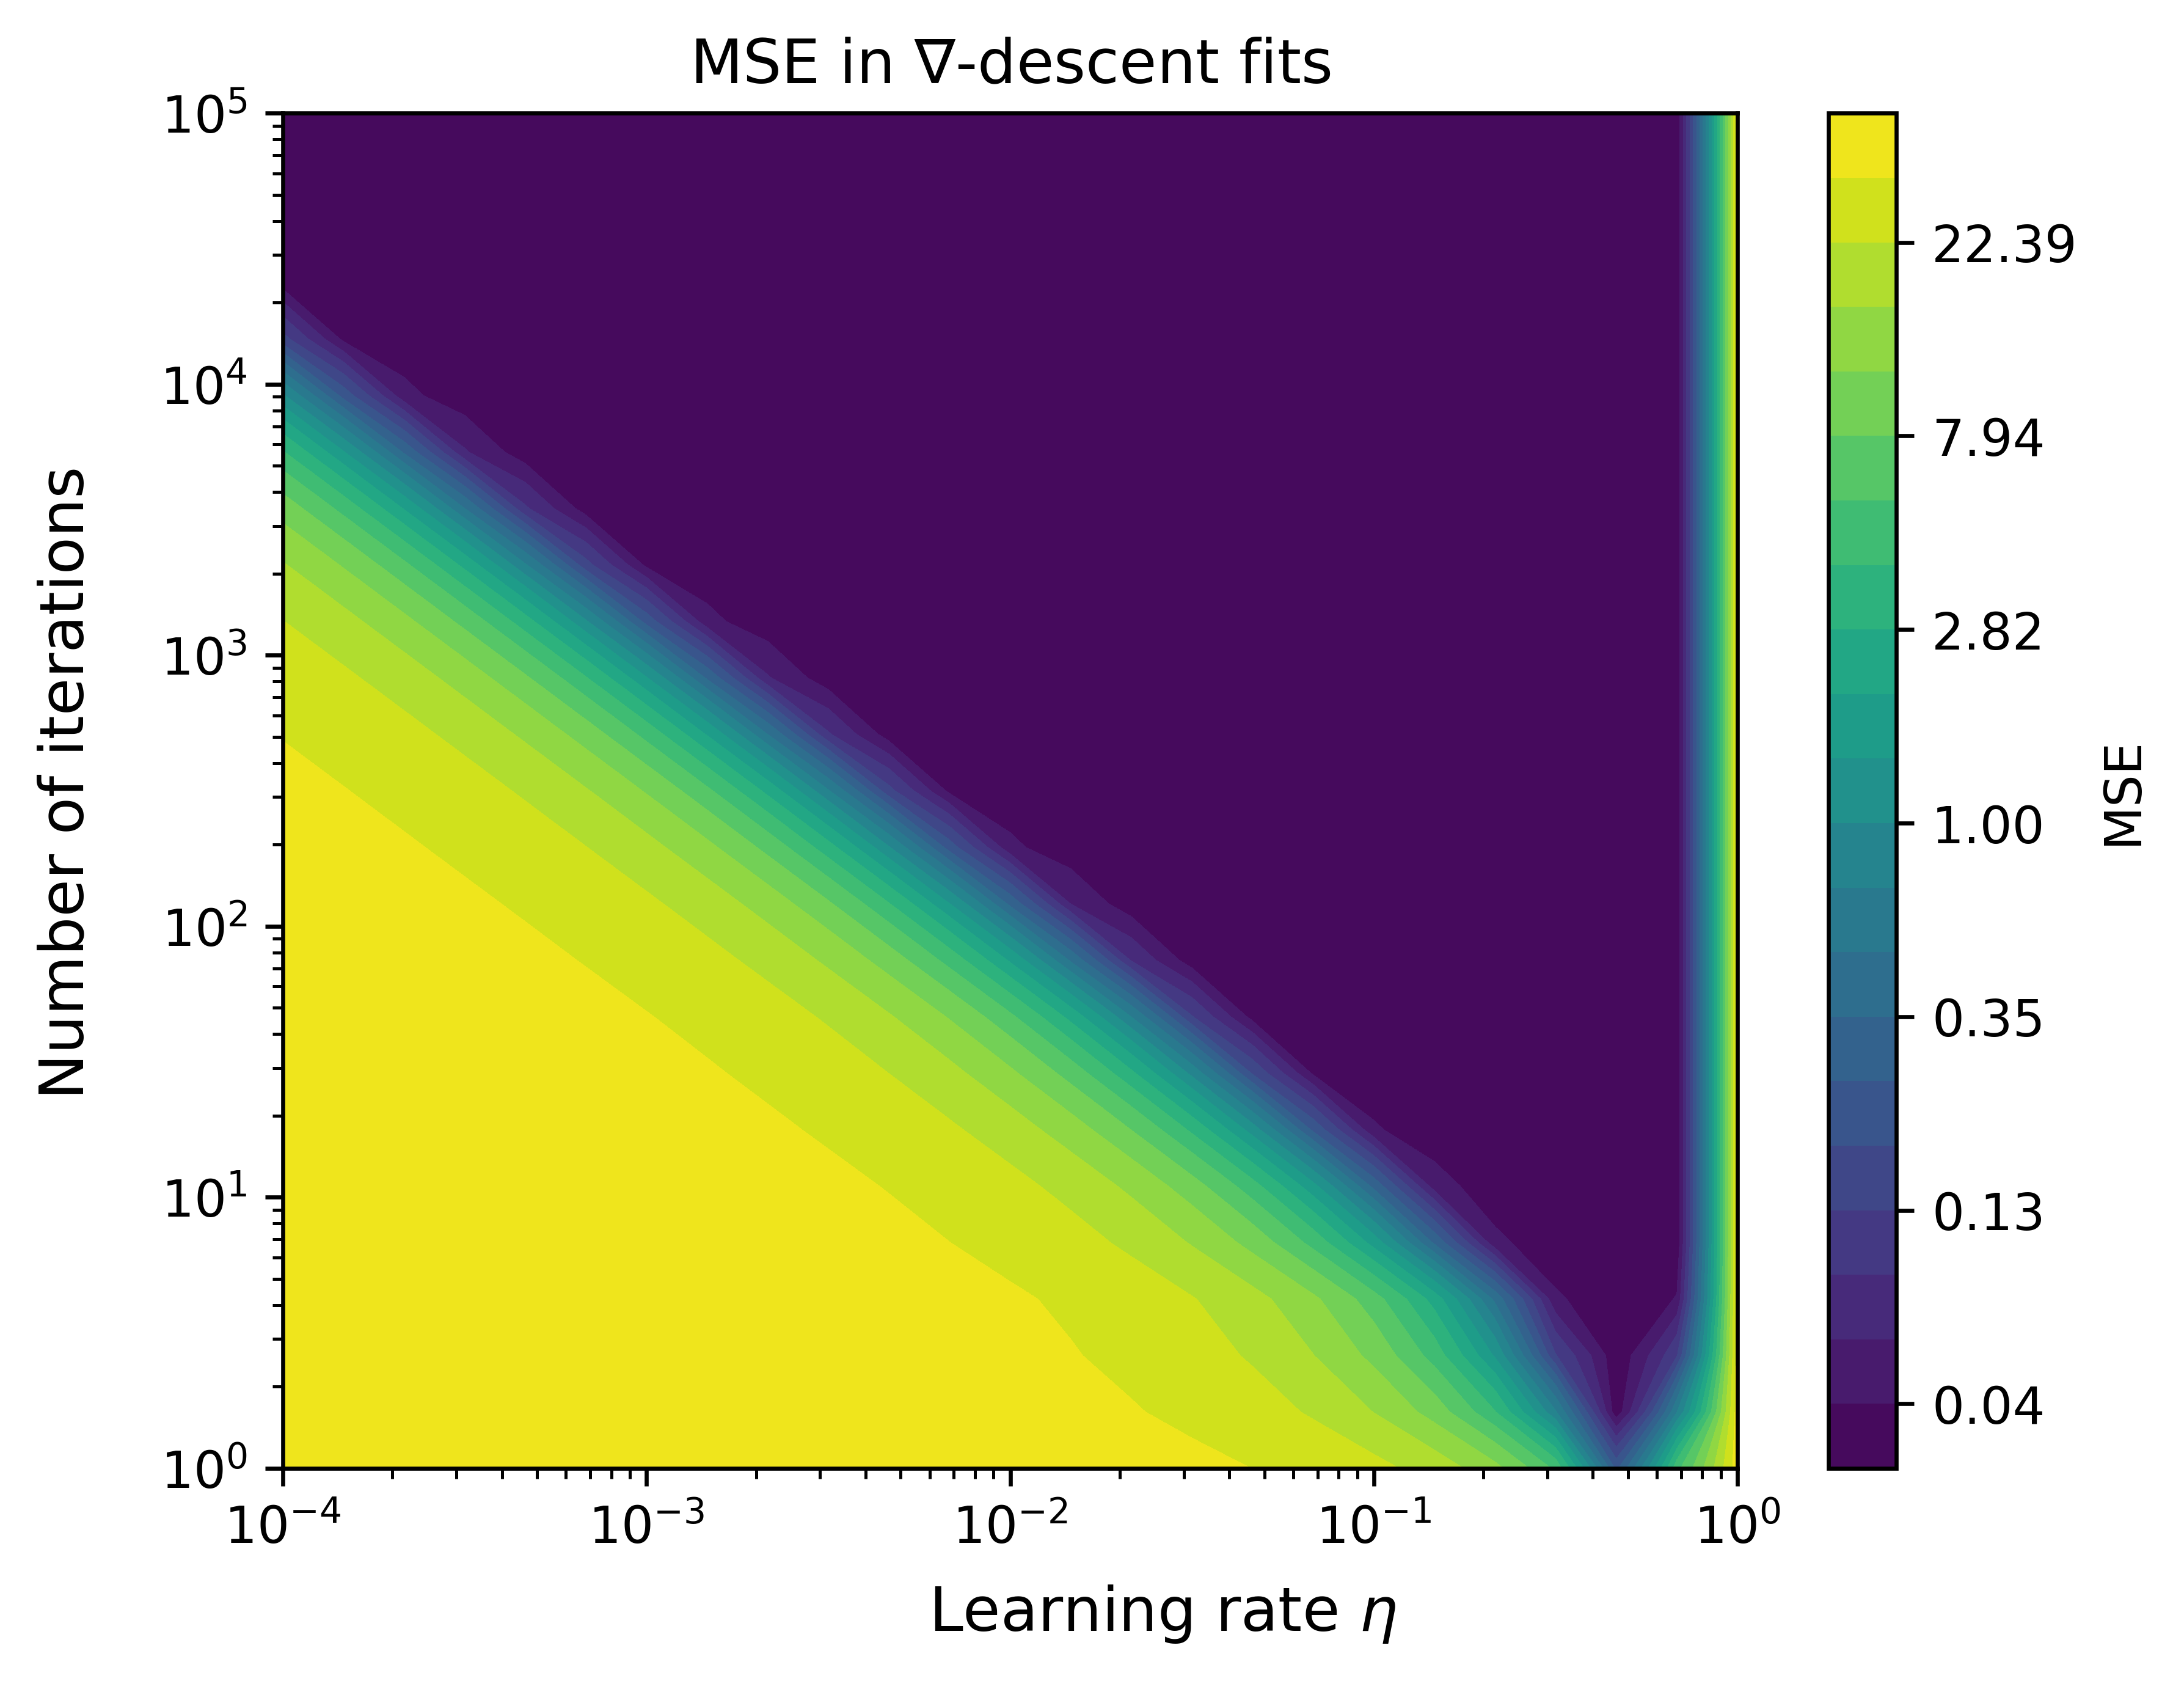

In [43]:
fig, ax = plt.subplots()

# levels = 10**mpl.ticker.MaxNLocator(40).tick_values(np.log10(errors.min()), np.log10(errors.max()))

# cf = ax.contourf(es, ns, errors, levels=levels)
cf = ax.contourf(es, ns, np.log10(errors), levels=20)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'MSE in $\nabla$-descent fits');

fig.supylabel('Number of iterations')
fig.supxlabel(r'Learning rate $\eta$')
fig.colorbar(cf, ax=ax, label=r'MSE',
             format=mpl.ticker.FuncFormatter(lambda x, _: f'{10**x:.2f}'))


### Discussion
One sees above that for this problem, the optimal parameters are found quickly with a high learning rate. Smaller learning rates need more iterations to find the right parameters.

### 4b)

Write then a similar code for Ridge regression using the above template.
Try to add a stopping parameter as function of the number iterations and the difference between the new and old $\theta$ values. How would you define a stopping criterion?

In [44]:
def descend_ridge(X, y, eta, num_iters, atol=1e-8, verb=False):
    theta = np.zeros(X.shape[1])
    for i in range(int(np.round(num_iters))):
        grad = ridge_grad(X, y, theta, lam=lam)

        theta -= eta*grad 

        # STOPPING CRITERION
        if (np.linalg.norm(grad) < atol):
            if (verb): print(f'Stopped after {i} iterations')
            break

    return theta, i

# run it once to make sure it works
descend_ridge(X_norm, y_centered, 1e-3, 1e5, verb=True)

Stopped after 10448 iterations


(array([-1.16906436,  6.07205429]), 10448)

Here the descent reached the stopping criterion after ~5000 iterations, half as many as it was called to do. The interesting thing to see is how many iterations it takes to reach the stopping criterion for a given eta, so let's do that:

In [45]:
descend_ridge_vec = np.vectorize(
    lambda eta, criterion: descend_ridge(X_norm, y_centered, eta, 1e5, atol=criterion),
    signature='(),()->(2),()')

n = 20
etas = np.logspace(-4,-1, n)
criteria = np.logspace(-1,-8, n)
es, cs = np.meshgrid(etas, criteria)

_, iterations = descend_ridge_vec(es, cs)


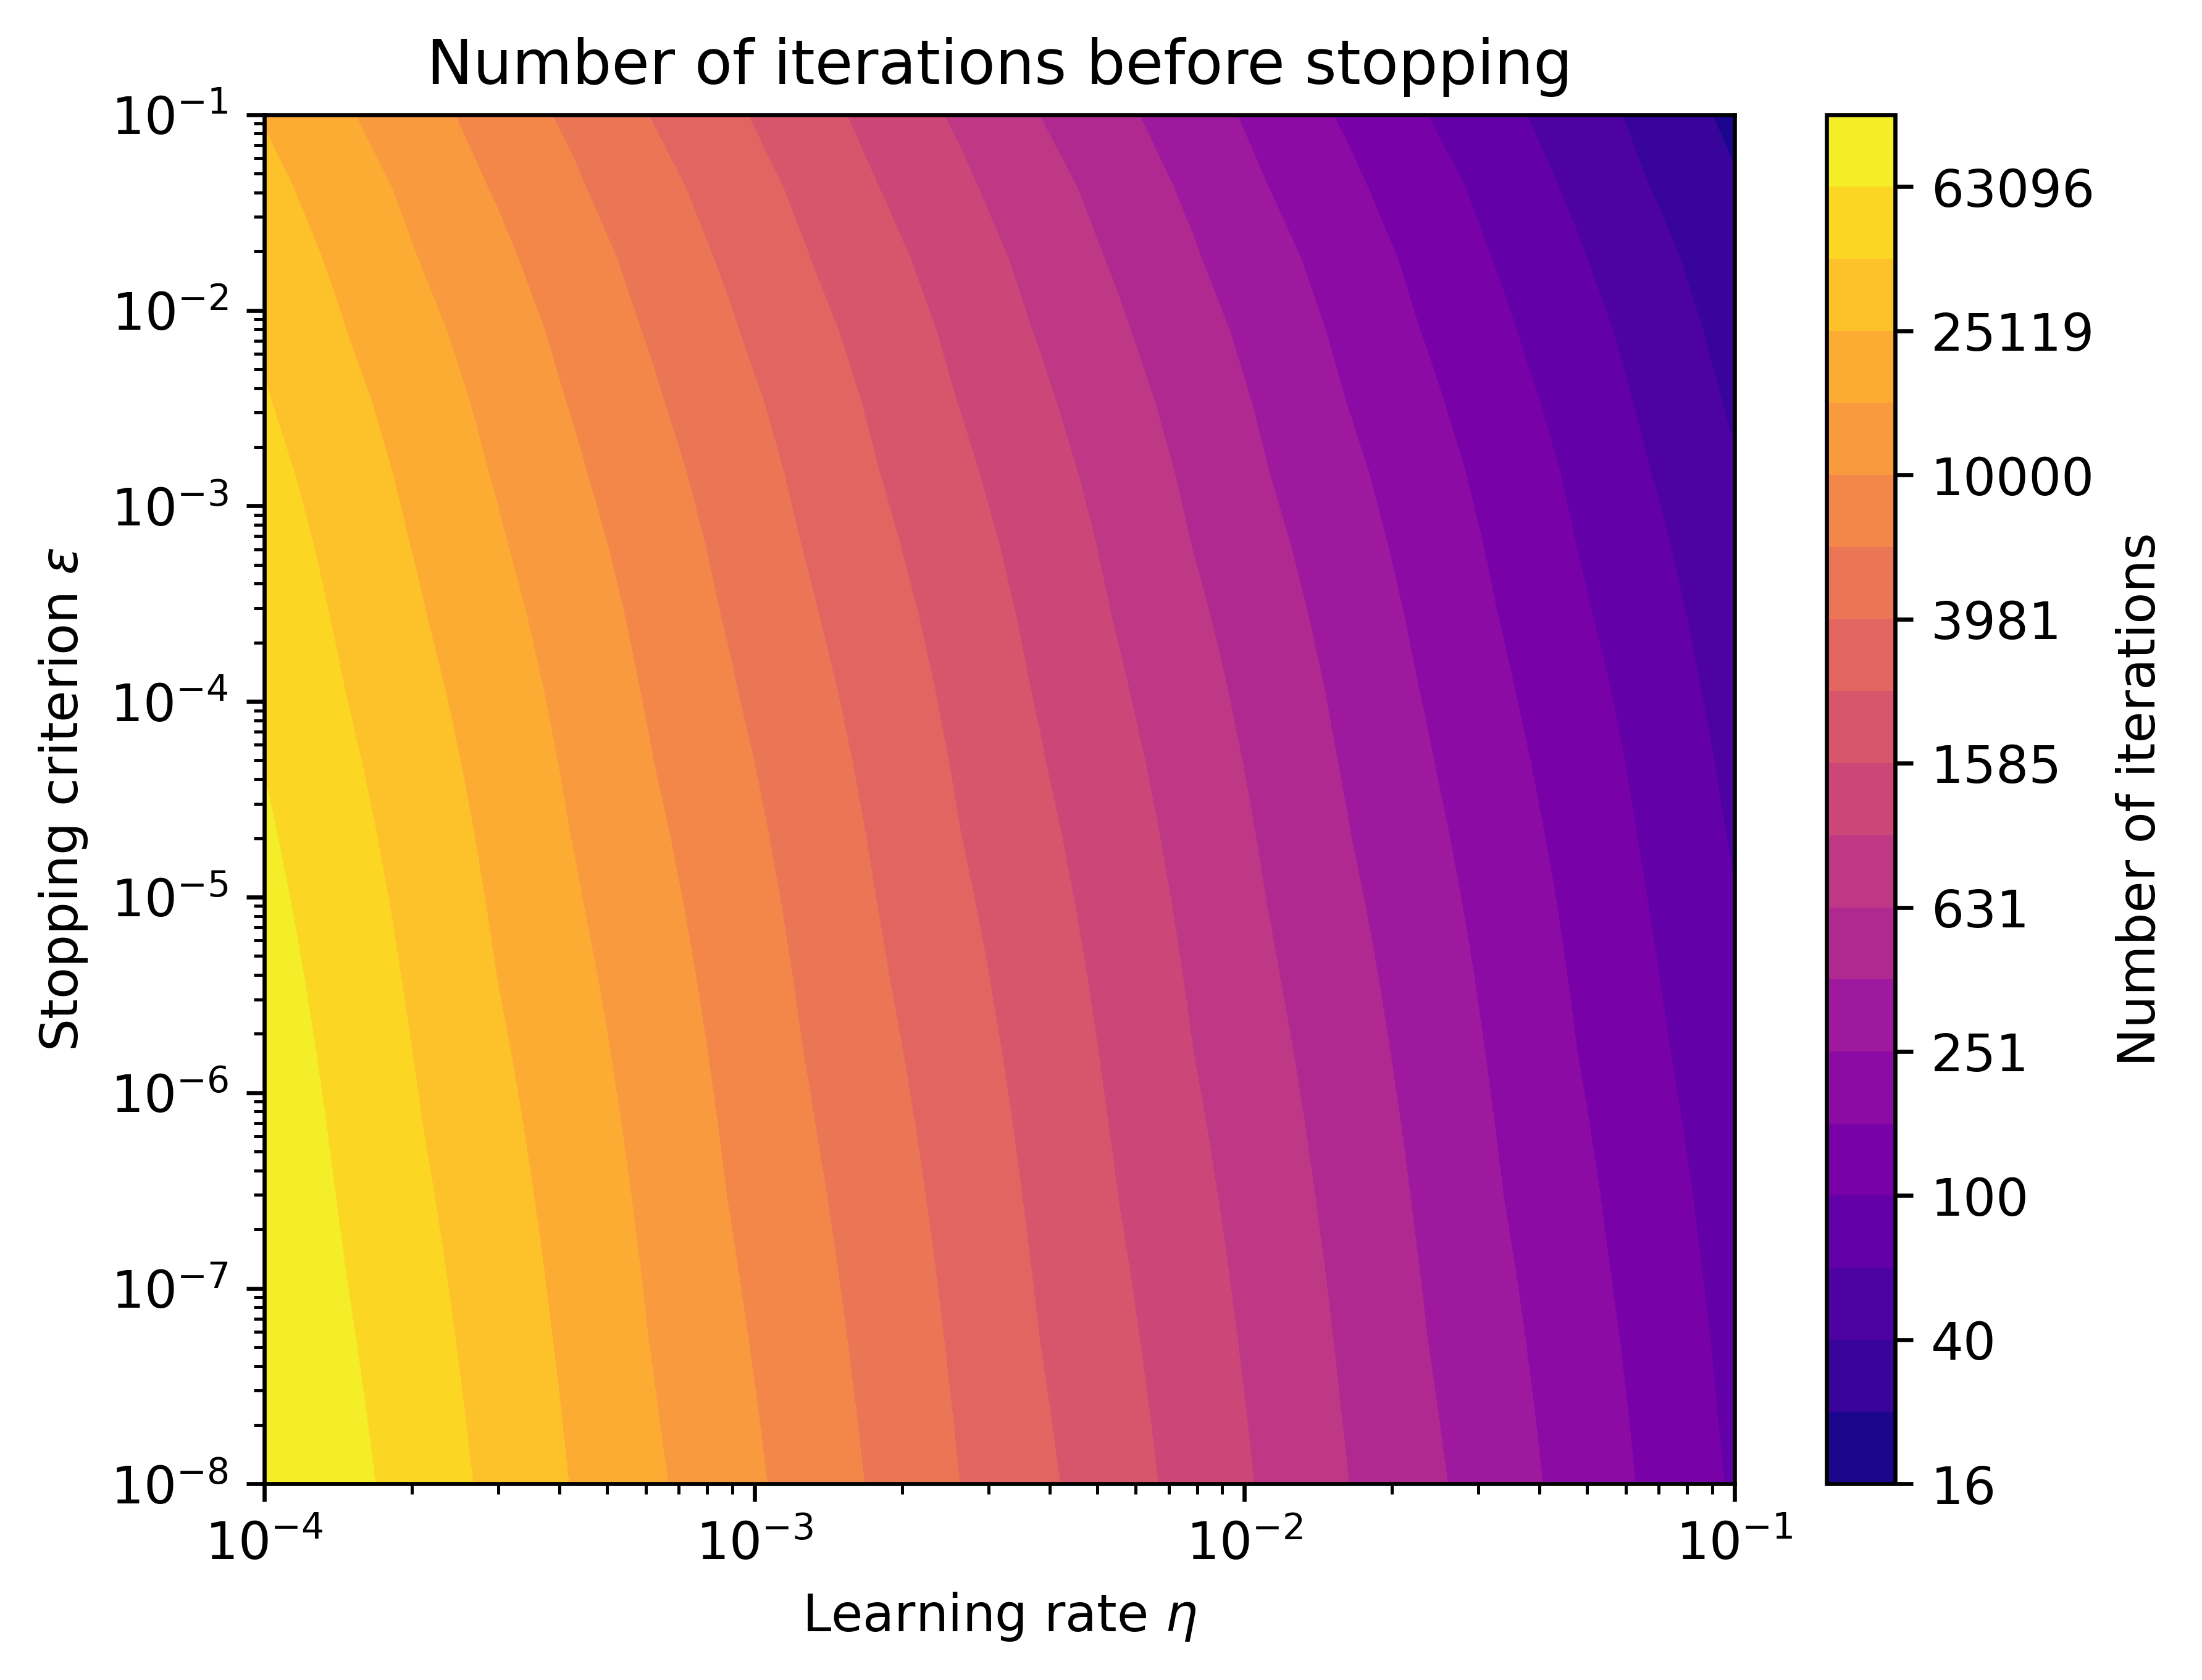

In [46]:
fig, ax = plt.subplots()

cf = ax.contourf(es, cs, np.log10(iterations), levels=20, cmap='plasma')

ax.set_xlabel(r'Learning rate $\eta$')
ax.set_ylabel(r'Stopping criterion $\epsilon$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(r'Number of iterations before stopping');

fig.colorbar(cf, ax=ax, label=r'Number of iterations',
             format=mpl.ticker.FuncFormatter(lambda x, _: f'{10**x:.0f}'))


### Interpretation

As expected for this problem, more iterations are needed for smaller learning rates. We can see also that a smaller stopping criterion does increase the number of iterations needed, though not dramatically so.

## Exercise 5, Ridge regression and a new Synthetic Dataset

We create a synthetic linear regression dataset with a sparse
underlying relationship. This means we have many features but only a
few of them actually contribute to the target. In our example, we’ll
use 10 features with only 3 non-zero weights in the true model. This
way, the target is generated as a linear combination of a few features
(with known coefficients) plus some random noise. The steps we include are:

Decide on the number of samples and features (e.g. 100 samples, 10 features).
Define the **true** coefficient vector with mostly zeros (for sparsity). For example, we set $\hat{\boldsymbol{\theta}} = [5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0]$, meaning only features 0, 1, and 6 have a real effect on y.

Then we sample feature values for $\boldsymbol{X}$ randomly (e.g. from a normal distribution). We use a normal distribution so features are roughly centered around 0.
Then we compute the target values $y$ using the linear combination $\boldsymbol{X}\hat{\boldsymbol{\theta}}$ and add some noise (to simulate measurement error or unexplained variance).

Below is the code to generate the dataset:

In [47]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(0)

# Define dataset size
n_samples = 100
n_features = 10

# Define true coefficients (sparse linear relationship)
theta_true = np.array([5.0, -3.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0])

# Generate feature matrix X (n_samples x n_features) with random values
X = np.random.randn(n_samples, n_features)  # standard normal distribution

# Generate target values y with a linear combination of X and theta_true, plus noise
noise = 0.5 * np.random.randn(n_samples)    # Gaussian noise
y = X @ theta_true + noise

This code produces a dataset where only features 0, 1, and 6
significantly influence $\boldsymbol{y}$. The rest of the features have zero true
coefficient. For example, feature 0 has
a true weight of 5.0, feature 1 has -3.0, and feature 6 has 2.0, so
the expected relationship is:

$$
y \approx 5 \times x_0 \;-\; 3 \times x_1 \;+\; 2 \times x_6 \;+\; \text{noise}.
$$

You can remove the noise if you wish to. 

Try to fit the above data set using OLS and Ridge regression with the analytical expressions and your own gradient descent codes.

If everything worked correctly, the learned coefficients should be
close to the true values [5.0, -3.0, 0.0, …, 2.0, …] that we used to
generate the data. Keep in mind that due to regularization and noise,
the learned values will not exactly equal the true ones, but they
should be in the same ballpark.  Which method (OLS or Ridge) gives the best results?

In [48]:
eta = 1e-3
n = 1e5

theta_ols = np.linalg.inv(X.T@X)@X.T@y
theta_ridge = np.linalg.inv(X.T @ X + lam*np.identity(X.shape[1])) @ X.T @ y

ols = descend_ols(X, y, eta, n)
# print('OLS descent:')
# print(ols)

ridge, _ = descend_ridge(X, y, eta, n)
# print('Ridge descent:')
# print(ridge)

print()
print('Comparison:')
print(f'{'Truth':>10}{'OLS':>10}{'OLS grad':>12}{'Ridge':>10}{'Ridge grad':>12}')
for i in range(len(theta_true)):
    print(f'{theta_true[i]:>10}{theta_ols[i]:>10.3f}{ols[i]:>12.3f}{theta_ridge[i]:>10.3f}{ridge[i]:>12.3f}')
# X.shape


Comparison:
     Truth       OLS    OLS grad     Ridge  Ridge grad
       5.0     5.009       5.009     5.009       5.004
      -3.0    -3.004      -3.004    -3.004      -3.000
       0.0    -0.016      -0.016    -0.016      -0.016
       0.0     0.145       0.145     0.145       0.145
       0.0    -0.072      -0.072    -0.072      -0.073
       0.0    -0.043      -0.043    -0.043      -0.044
       2.0     2.056       2.056     2.056       2.053
       0.0     0.002       0.002     0.002       0.002
       0.0     0.041       0.041     0.041       0.040
       0.0    -0.051      -0.051    -0.051      -0.051


Here, the gradient descent algorithms converged to the same values as the analytical solutions.